Connected to .venv (Python 3.10.7)

 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

2024-12-12 03:19:04.094753: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 03:19:04.109735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 03:19:04.117863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 03:19:04.120275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 03:19:04.126472: I tensorflow/core/platform/cpu_feature_guar

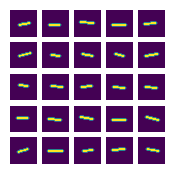

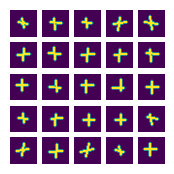

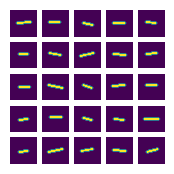

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='-'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=False)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=False)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #4832

X_text: "24+16" = y_text: " 40"


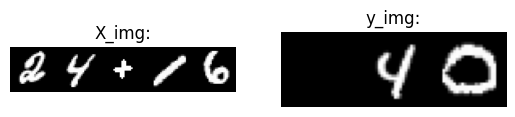

Query #2306

X_text: "11+53" = y_text: " 64"


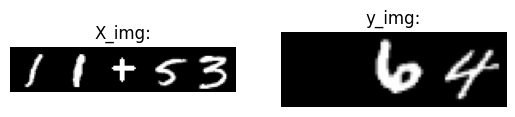

Query #8579

X_text: "42-89" = y_text: "-47"


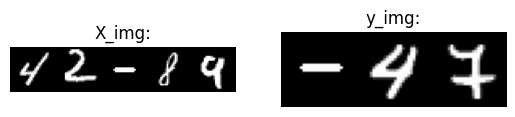

Query #5732

X_text: "28+66" = y_text: " 94"


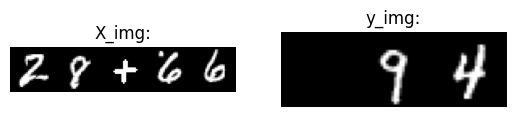

Query #395

X_text: " 1-97" = y_text: "-96"


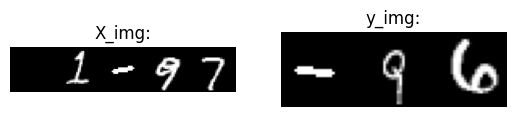

Query #824

X_text: " 4+12" = y_text: " 16"


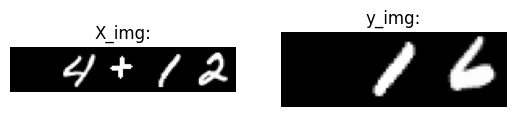

Query #9863

X_text: "49-31" = y_text: " 18"


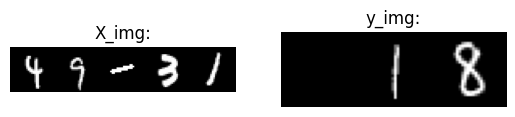

Query #253

X_text: " 1-26" = y_text: "-25"


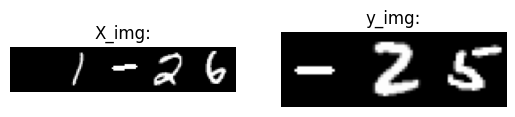

Query #4918

X_text: "24+59" = y_text: " 83"


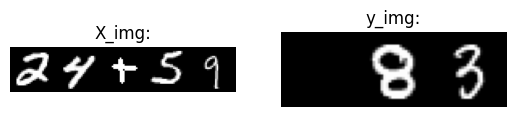

Query #9756

X_text: "48+78" = y_text: "126"


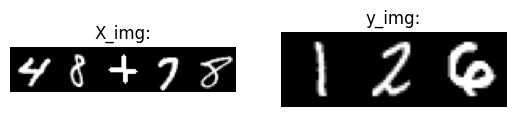

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)



 ## II. Image to text RNN Model

 Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or
 recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

 The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.20, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

-70


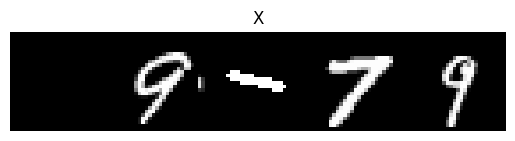

In [ ]:
print(decode_labels(y_test[0]))

plt.imshow(np.hstack(X_test[0]), cmap='gray')  # Display the frame in grayscale
plt.title(f"X")
plt.axis("off")
plt.show()

In [ ]:
## Your code
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, ConvLSTM2D,MaxPooling2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def build_img2text_model():
    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(
        ConvLSTM2D(filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        input_shape=(5, 28, 28, 1), 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))
    
    img2text.add(
        ConvLSTM2D(filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())

    #img2text.add(Flatten())
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))

    # Next we compile the model using categorical crossentropy as our loss function.
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    img2text.summary()

    return img2text

def build_img2text_model2():
    img2text = tf.keras.Sequential()
    img2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    img2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    img2text.add(TimeDistributed(Dropout(0.2)))
    img2text.add(TimeDistributed(Flatten()))
    img2text.add(TimeDistributed(Dense(256, activation='relu')))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256))
    
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text

model = build_img2text_model2()

/vol/home/s3777103/Documents/workspace/Sem1/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1733969988.107082 1143507 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733969988.132862 1143507 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733969988.132950 1143507 cuda_executor.cc:1015] suc

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 26, 26, 512) │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 86528)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 256)         │    22,151,424 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,735,821 (90.54 MB)

 Trainable params: 23,735,821 (90.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras as keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
## Your code
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, ConvLSTM2D,MaxPooling2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def build_img2text_model():
    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(
        ConvLSTM2D(filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        input_shape=(5, 28, 28, 1), 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))
    
    img2text.add(
        ConvLSTM2D(filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())

    #img2text.add(Flatten())
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))

    # Next we compile the model using categorical crossentropy as our loss function.
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    img2text.summary()

    return img2text

def build_img2text_model2():
    img2text = tf.keras.Sequential()
    img2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    img2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    img2text.add(TimeDistributed(Dropout(0.2)))
    img2text.add(TimeDistributed(Flatten()))
    img2text.add(TimeDistributed(Dense(200, activation='relu')))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256))
    
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text

model = build_img2text_model2()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_6              │ (None, 5, 26, 26, 512) │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 86528)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 5, 200)         │    17,305,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 256)         │       467,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,832,853 (71.84 MB)

 Trainable params: 18,832,853 (71.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras as keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/100


2024-12-12 03:22:18.989472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/time_distributed_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-12 03:22:19.157915: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1733970139.194842 1143641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970139.209531 1143641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970139.210298 1143641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970139.215910 1143641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970139.216679 1143641 gpu_timer.cc:114] Skipping the delay kernel, mea

   7/2000 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.1066 - loss: 2.5473

W0000 00:00:1733970140.266458 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.267481 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.268187 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.268900 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.269618 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.270759 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.271705 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.272602 1143649 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970140.273519 1143649 gp

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 60s 29ms/step - accuracy: 0.2708 - loss: 1.8838 - val_accuracy: 0.3297 - val_loss: 1.7137 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.3746 - loss: 1.5972 - val_accuracy: 0.2302 - val_loss: 3.0393 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.4919 - loss: 1.3043 - val_accuracy: 0.2113 - val_loss: 3.3799 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.5644 - loss: 1.1566 - val_accuracy: 0.2237 - val_loss: 3.4872 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.6106 - loss: 1.0548 - val_accuracy: 0.2583 - val_loss: 3.4222 - learning_rate: 0.0010
Epoch 6/100
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6861 - loss: 0.8796
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.68

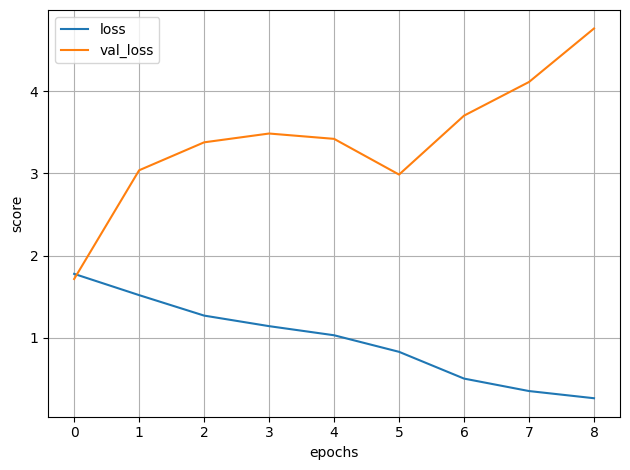

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3451 - loss: 1.6727
Train Accuracy for text to text model: [1.6709380149841309, 0.344145804643631]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3451 - loss: 1.6697
Test Accuracy for text to text model: [1.6711069345474243, 0.3429999351501465]


In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")

plt.grid(True)
plt.tight_layout()
plt.show()

print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for image to text model:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy for image to text model: 0.0155


In [ ]:
import tensorflow.keras as keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=15,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/100


W0000 00:00:1733970807.658176 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970807.875523 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970807.876618 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970807.877691 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970807.878772 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970807.879847 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970808.114741 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970808.116356 1143644 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970808.118222 1143644 gp

  1/250 ━━━━━━━━━━━━━━━━━━━━ 12:15 3s/step - accuracy: 0.3229 - loss: 1.6784

W0000 00:00:1733970809.289471 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.351430 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.353016 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.354554 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.356384 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.358200 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.360028 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.361892 1143647 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970809.363757 1143647 gp

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3562 - loss: 1.6319

W0000 00:00:1733970838.344855 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.345973 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.347003 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.348112 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.349278 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.350479 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.351719 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.353015 1143624 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733970838.354672 1143624 gp

250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - accuracy: 0.3562 - loss: 1.6318 - val_accuracy: 0.3872 - val_loss: 1.5621 - learning_rate: 5.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.3973 - loss: 1.5483 - val_accuracy: 0.4115 - val_loss: 1.4913 - learning_rate: 5.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.4273 - loss: 1.4580 - val_accuracy: 0.4608 - val_loss: 1.3948 - learning_rate: 5.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.4699 - loss: 1.3787 - val_accuracy: 0.4820 - val_loss: 1.3286 - learning_rate: 5.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.5025 - loss: 1.3074 - val_accuracy: 0.5085 - val_loss: 1.2924 - learning_rate: 5.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.5209 - loss: 1.2614 - val_accuracy: 0.5200 - val_loss: 1.2442 - learning_rate: 5.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/s

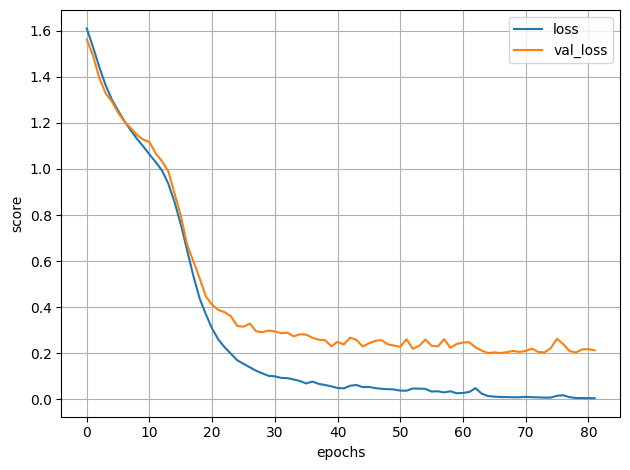

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9983 - loss: 0.0079
Train Accuracy for text to text model: [0.008325244300067425, 0.9981045126914978]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9708 - loss: 0.1877
Test Accuracy for text to text model: [0.19848766922950745, 0.9693332314491272]


In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")

plt.grid(True)
plt.tight_layout()
plt.show()

print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for image to text model:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy for image to text model: 0.0245


In [ ]:
y_pred

['-60',
 ' 11',
 '-10',
 ' 85',
 ' 43',
 ' 13',
 '-17',
 '-32',
 ' 30',
 ' 31',
 '-79',
 ' 31',
 '-39',
 '-44',
 '-52',
 '-79',
 '141',
 ' 73',
 ' 27',
 '-43',
 '-42',
 ' 21',
 '-17',
 ' -7',
 '  3',
 ' 11',
 '-82',
 ' 47',
 ' 92',
 '-78',
 ' 38',
 '-61',
 '129',
 ' 57',
 '-56',
 ' -2',
 ' 71',
 '158',
 ' 39',
 '-37',
 '-20',
 '-51',
 '150',
 '-62',
 '-43',
 '-18',
 '-71',
 '  1',
 ' 32',
 '183',
 ' 13',
 ' -2',
 ' 65',
 '159',
 ' -2',
 ' 11',
 '-72',
 '  3',
 '1 2',
 '181',
 ' 13',
 ' 68',
 ' 99',
 '-77',
 '-17',
 ' 79',
 '-48',
 ' 71',
 '-17',
 '-57',
 ' 28',
 '  2',
 '-28',
 ' 27',
 '-70',
 ' 85',
 '118',
 '-38',
 '  2',
 '-42',
 '-72',
 ' -2',
 '-99',
 ' 51',
 ' 20',
 ' 46',
 '100',
 ' 69',
 '169',
 ' 20',
 ' 72',
 ' 61',
 ' 11',
 '-48',
 ' 48',
 ' 42',
 ' 68',
 '  0',
 '131',
 '-73',
 ' 31',
 '198',
 ' 75',
 '-32',
 '-21',
 ' 99',
 '-89',
 ' 28',
 '119',
 '-91',
 ' 28',
 '188',
 '-69',
 '159',
 ' -7',
 '-28',
 '-28',
 '-26',
 ' 48',
 ' 48',
 '-12',
 ' 31',
 '128',
 '-18',
 '-57',


In [ ]:
y_actual

['-70',
 ' 11',
 '111',
 ' 63',
 '164',
 ' 17',
 '-35',
 '-24',
 ' 43',
 ' 39',
 ' 61',
 ' 78',
 '  0',
 '123',
 '-53',
 '115',
 ' 71',
 ' 78',
 ' -3',
 '-23',
 '-63',
 ' 39',
 ' 11',
 '193',
 ' 48',
 '  3',
 ' 51',
 ' -7',
 '140',
 '111',
 ' 56',
 '-71',
 '135',
 ' 33',
 ' 37',
 '-27',
 ' 78',
 '136',
 '155',
 '149',
 '-20',
 '-13',
 '158',
 '-54',
 '150',
 '-54',
 '-36',
 '-38',
 ' 80',
 '145',
 ' 30',
 '-12',
 ' 40',
 '140',
 ' 38',
 '107',
 '-33',
 ' 21',
 '163',
 '146',
 ' 16',
 ' -2',
 ' 57',
 '-92',
 ' 91',
 ' 92',
 '  3',
 ' 50',
 ' 82',
 '-34',
 '-10',
 ' -8',
 '116',
 ' -1',
 '-59',
 ' 85',
 '146',
 ' -7',
 '-11',
 ' 40',
 ' 75',
 ' -6',
 '107',
 '104',
 '-59',
 '130',
 '155',
 ' 52',
 '134',
 ' 11',
 ' 85',
 ' 12',
 ' 10',
 '-20',
 ' 66',
 '129',
 '119',
 '-26',
 '120',
 '-77',
 ' 78',
 '173',
 ' 94',
 '-28',
 '132',
 ' 77',
 '104',
 ' -3',
 '100',
 '109',
 '119',
 '117',
 ' 73',
 '169',
 ' -1',
 ' 94',
 ' 71',
 '-31',
 ' 36',
 ' 44',
 '-10',
 ' 12',
 '108',
 ' 32',
 ' 62',


In [ ]:
accuracy_score(y_actual[:3], y_pred[:3])

0.3333333333333333

 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

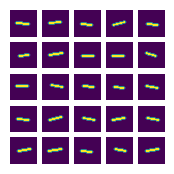

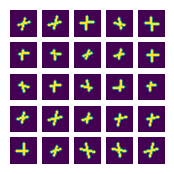

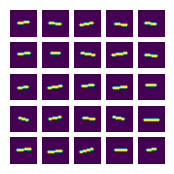

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='-'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #1834

X_text: "9+17 " = y_text: "26 "


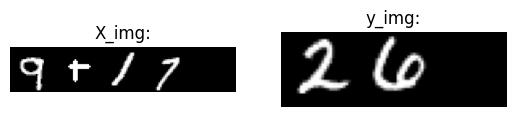

Query #7875

X_text: "39-37" = y_text: "2  "


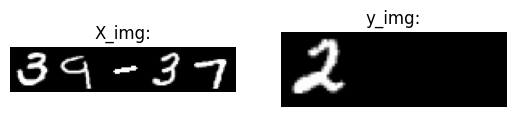

Query #5670

X_text: "28+35" = y_text: "63 "


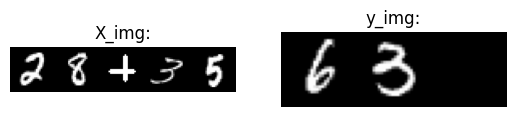

Query #8093

X_text: "40-46" = y_text: "-6 "


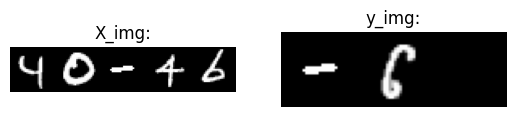

Query #4769

X_text: "23-84" = y_text: "-61"


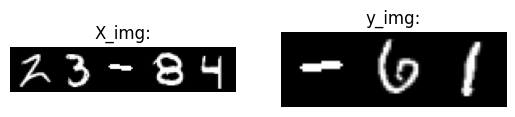

Query #1923

X_text: "9-61 " = y_text: "-52"


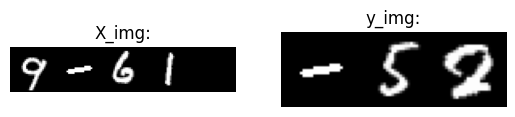

Query #1344

X_text: "6+72 " = y_text: "78 "


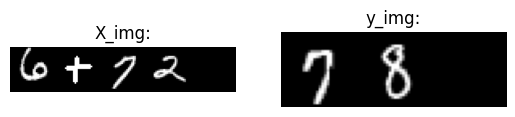

Query #1973

X_text: "9-86 " = y_text: "-77"


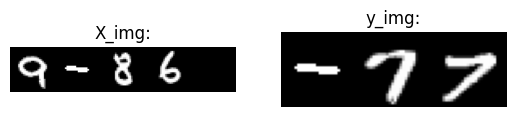

Query #2498

X_text: "12+49" = y_text: "61 "


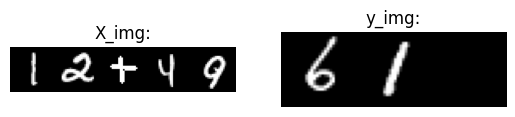

Query #9396

X_text: "46+98" = y_text: "144"


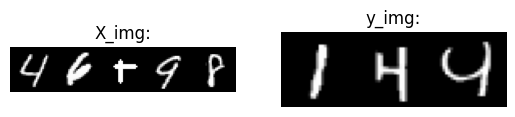

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)



 ## II. Image to text RNN Model

 Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or
 recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

 The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.20, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

-70


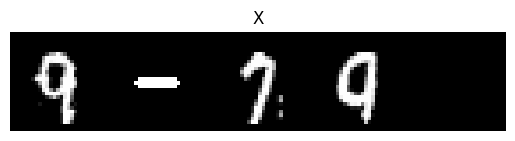

In [ ]:
print(decode_labels(y_test[0]))

plt.imshow(np.hstack(X_test[0]), cmap='gray')  # Display the frame in grayscale
plt.title(f"X")
plt.axis("off")
plt.show()

In [ ]:
## Your code
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, ConvLSTM2D,MaxPooling2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def build_img2text_model():
    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(
        ConvLSTM2D(filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        input_shape=(5, 28, 28, 1), 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))
    
    img2text.add(
        ConvLSTM2D(filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())

    #img2text.add(Flatten())
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))

    # Next we compile the model using categorical crossentropy as our loss function.
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    img2text.summary()

    return img2text

def build_img2text_model2():
    img2text = tf.keras.Sequential()
    img2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    img2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    img2text.add(TimeDistributed(Dropout(0.2)))
    img2text.add(TimeDistributed(Flatten()))
    img2text.add(TimeDistributed(Dense(200, activation='relu')))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256))
    
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text

model = build_img2text_model2()

/vol/home/s3777103/Documents/workspace/Sem1/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_12             │ (None, 5, 26, 26, 512) │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 5, 86528)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 5, 200)         │    17,305,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 5, 256)         │       467,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,832,853 (71.84 MB)

 Trainable params: 18,832,853 (71.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras as keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=15,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/100


2024-12-12 04:30:40.123127: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/time_distributed_14_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
W0000 00:00:1733974240.290830 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


  2/250 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.1055 - loss: 2.5537

W0000 00:00:1733974240.361037 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.362226 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.363381 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.364501 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.365649 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.366918 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.368730 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.370739 1143629 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733974240.372566 1143629 gp

250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.3196 - loss: 2.0917 - val_accuracy: 0.4067 - val_loss: 1.7344 - learning_rate: 0.0010
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.4151 - loss: 1.6786 - val_accuracy: 0.4617 - val_loss: 1.4851 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.4889 - loss: 1.4210 - val_accuracy: 0.5357 - val_loss: 1.3029 - learning_rate: 0.0010
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.5567 - loss: 1.2385 - val_accuracy: 0.5782 - val_loss: 1.2110 - learning_rate: 0.0010
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.5895 - loss: 1.1406 - val_accuracy: 0.6003 - val_loss: 1.1441 - learning_rate: 0.0010
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.6197 - loss: 1.0464 - val_accuracy: 0.6142 - val_loss: 1.0848 - learning_rate: 0.0010
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.6370 -

In [ ]:
model.save(f'submission1_image_to_text.keras')

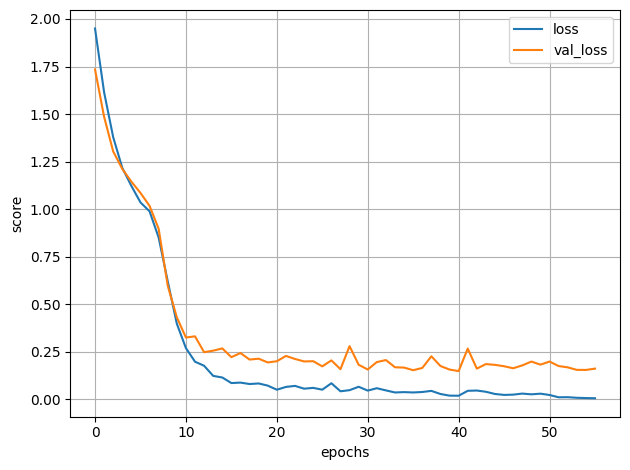

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9965 - loss: 0.0126
Train Accuracy for text to text model: [0.014029748737812042, 0.9962506294250488]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9794 - loss: 0.1409
Test Accuracy for text to text model: [0.1635618358850479, 0.9763333797454834]


In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")

plt.grid(True)
plt.tight_layout()
plt.show()

print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for image to text model:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy for image to text model: 0.012


In [ ]:
## Your code
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, ConvLSTM2D,MaxPooling2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def build_img2text_model():
    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(
        ConvLSTM2D(filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        input_shape=(5, 28, 28, 1), 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))
    
    img2text.add(
        ConvLSTM2D(filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())

    #img2text.add(Flatten())
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))

    # Next we compile the model using categorical crossentropy as our loss function.
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    img2text.summary()

    return img2text

def build_img2text_model2():
    img2text = tf.keras.Sequential()
    img2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    img2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    img2text.add(TimeDistributed(Dropout(0.2)))
    img2text.add(TimeDistributed(Flatten()))
    img2text.add(TimeDistributed(Dense(200, activation='relu')))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256))
    
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text

model = build_img2text_model2()

/vol/home/s3777103/Documents/workspace/Sem1/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_18             │ (None, 5, 26, 26, 512) │         5,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 5, 13, 13, 512) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 5, 86528)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 5, 200)         │    17,305,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 5, 256)         │       467,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,832,853 (71.84 MB)

 Trainable params: 18,832,853 (71.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras as keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/100
   1/2000 ━━━━━━━━━━━━━━━━━━━━ 45:36 1s/step - accuracy: 0.1667 - loss: 2.5644

2024-12-12 04:58:21.553293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/time_distributed_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 59s 29ms/step - accuracy: 0.3709 - loss: 1.9193 - val_accuracy: 0.2425 - val_loss: 3.0279 - learning_rate: 0.0010
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.4909 - loss: 1.4178 - val_accuracy: 0.2977 - val_loss: 2.7462 - learning_rate: 0.0010
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.5842 - loss: 1.1730 - val_accuracy: 0.2800 - val_loss: 3.0393 - learning_rate: 0.0010
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.7033 - loss: 0.8498 - val_accuracy: 0.2650 - val_loss: 3.7575 - learning_rate: 0.0010
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.8335 - loss: 0.5540 - val_accuracy: 0.2718 - val_loss: 4.9055 - learning_rate: 0.0010
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 56s 28ms/step - accuracy: 0.8883 - loss: 0.3987 - val_accuracy: 0.2468 - val_loss: 5.5557 - learning_rate: 0.0010
Epoch 7/100
1999/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.

In [ ]:
model.save(f'submission1_image_to_text.keras')

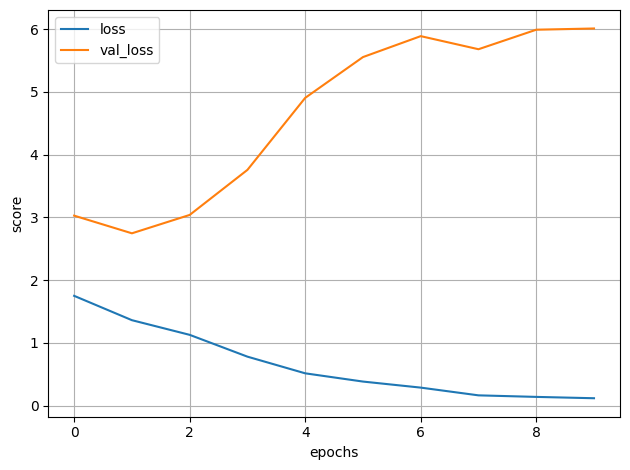

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5623 - loss: 1.2233
Train Accuracy for text to text model: [1.2218360900878906, 0.562437891960144]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5565 - loss: 1.2430
Test Accuracy for text to text model: [1.243869423866272, 0.5541666150093079]


In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")

plt.grid(True)
plt.tight_layout()
plt.show()

print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]

accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for image to text model:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy for image to text model: 0.007


In [ ]:
X_train.shape

(16000, 5, 28, 28)

In [ ]:
X_test.shape

(2000, 5, 28, 28)

In [ ]:
X_valid.shape

(2000, 5, 28, 28)